In [1]:
from rostering_solver import Instance, Solver
import pandas as pd
import numpy as np
import json
import random
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
city = 'berlin'
demand_baseline = "1.00"
week_demand_type = "doublepeak" # "fixed" demand_type
weekend_demand_type = "uniform"

outsourcing_cost_multiplier = 1.5
model = "flex" # "fixed" # "flex"
multiple_scenario = True

read_instance_file = False

min_multiple_scenario = float('inf')

In [3]:
if read_instance_file:
    demand_file = f'{city}_db={demand_baseline}_dt={week_demand_type}.csv'
    print(demand_file)

    demand_df = pd.read_csv(demand_file, index_col=0)
    demand_df['area_id'] = demand_df['area_id'].astype(str) 
    days_ = []
    for i in range(7):
        days_.append([i, "1.00", "uniform"])
    days = pd.DataFrame(days_, columns=['day', 'demand_baseline', 'demand_type']) 
else:
    # Generate instance file
    # Generate several days instances 
    days = pd.DataFrame([
        [0, demand_baseline, week_demand_type], # Monday
        [1, demand_baseline, week_demand_type], # Tuesday
        [2, demand_baseline, week_demand_type], # Wednesday
        [3, demand_baseline, week_demand_type], # Thursday
        [4, demand_baseline, week_demand_type], # Friday
        [5, demand_baseline, weekend_demand_type], # Satuday
        [6, demand_baseline, weekend_demand_type], # Sunday
    ], columns=['day', 'demand_baseline', 'demand_type']
    )

    demand = []
    area_region_map = None

    for i, row in days.iterrows():
        demand_baseline, demand_type = row['demand_baseline'], row['demand_type']
        key = f'{city}_db={demand_baseline}_dt={demand_type}'

        instance_file = f'../instances/{city}_db={demand_baseline}_dt={demand_type}.json'
        with open(instance_file, 'r') as file:
            instance_data = json.load(file)

        if area_region_map is None:
            regions = instance_data['geography']['city']['regions']
            area_region_map = {}
            for region in regions:
                areas = region['areas'] 
                for area in areas:
                    area_region_map[area['id']] = region['id']
        
        if multiple_scenario:
            if instance_data['num_scenarios'] < min_multiple_scenario:
                min_multiple_scenario = instance_data['num_scenarios']
                
            for scenario in range(instance_data['num_scenarios']):
                data_ = (
                    pd.DataFrame(instance_data['scenarios'][scenario]['data'])
                    .assign(
                        day = row['day'],
                        scenario = scenario
                    )
                )
                demand.append(data_)
        else:
            scenario = random.randint(0, instance_data['num_scenarios']-1)
            data_ = (
                pd.DataFrame(instance_data['scenarios'][scenario]['data'])
                .assign(
                    day = row['day']
                )
            )
            demand.append(data_)

In [4]:
if multiple_scenario:
    demand_ = []
    demand_scenarios_df = pd.concat(demand)
    for theta in range(8):
        demand_scenarios_df[f'demand_{theta}'] = demand_scenarios_df['demand'].apply(lambda x: x[theta])
        demand_scenarios_df[f'required_couriers_{theta}'] = demand_scenarios_df['required_couriers'].apply(lambda x: x[theta])

        demand_scenarios_df.groupby(['area_id', 'day'])[f'demand_{theta}'].mean()
        demand_.append( pd.concat([demand_scenarios_df.groupby(['area_id', 'day'])[f'demand_{theta}'].mean().apply(lambda x: round(x, 2)).to_frame(), 
                                  demand_scenarios_df.groupby(['area_id', 'day'])[f'required_couriers_{theta}'].mean().apply(lambda x: round(x)).to_frame()], axis='columns'
                                  ))
        
    demand_df = pd.concat(demand_, axis='columns').reset_index()
    demand_df['demand'] = demand_df[[ f'demand_{theta}' for theta in range(8) ]].apply(lambda x: list(x), axis=1)
    demand_df['required_couriers'] = demand_df[[ f'required_couriers_{theta}' for theta in range(8) ]].apply(lambda x: list(x), axis=1)

else:
    demand_df = pd.concat(demand)

demand_df['region_id'] = demand_df['area_id'].map(area_region_map)
demand_df = demand_df[['day', 'region_id', 'area_id', 'demand', 'required_couriers']]
demand_df.head(20)

,day,region_id,area_id,demand,required_couriers
0,0,1,10115,"[0.3, 1.83, 3.83, 3.6, 3.33, 3.83, 1.97, 0.37]","[0, 1, 1, 1, 1, 1, 1, 0]"
1,1,1,10115,"[0.3, 1.83, 3.83, 3.6, 3.33, 3.83, 1.97, 0.37]","[0, 1, 1, 1, 1, 1, 1, 0]"
2,2,1,10115,"[0.3, 1.83, 3.83, 3.6, 3.33, 3.83, 1.97, 0.37]","[0, 1, 1, 1, 1, 1, 1, 0]"
3,3,1,10115,"[0.3, 1.83, 3.83, 3.6, 3.33, 3.83, 1.97, 0.37]","[0, 1, 1, 1, 1, 1, 1, 0]"
4,4,1,10115,"[0.3, 1.83, 3.83, 3.6, 3.33, 3.83, 1.97, 0.37]","[0, 1, 1, 1, 1, 1, 1, 0]"
5,5,1,10115,"[2.57, 2.13, 2.43, 2.03, 2.5, 2.4, 2.7, 2.33]","[1, 1, 1, 1, 1, 1, 1, 1]"
6,6,1,10115,"[2.57, 2.13, 2.43, 2.03, 2.5, 2.4, 2.7, 2.33]","[1, 1, 1, 1, 1, 1, 1, 1]"
7,0,1,10117,"[0.07, 1.9, 3.4, 2.67, 2.77, 3.67, 1.3, 0.17]","[0, 1, 1, 1, 1, 1, 1, 0]"
8,1,1,10117,"[0.07, 1.9, 3.4, 2.67, 2.77, 3.67, 1.3, 0.17]","[0, 1, 1, 1, 1, 1, 1, 0]"
9,2,1,10117,"[0.07, 1.9, 3.4, 2.67, 2.77, 3.67, 1.3, 0.17]","[0, 1, 1, 1, 1, 1, 1, 0]"


In [5]:
# READ SHIFTS
key = f'{city}_db={demand_baseline}_dt={demand_type}'

shifts_file = f'../shifts/{city}_db={demand_baseline}_dt={demand_type}.json'
with open(shifts_file, 'r') as file:
    shifts_data = json.load(file)

shifts_df = (
    pd.DataFrame(shifts_data).query(f'outsourcing_cost_multiplier == {outsourcing_cost_multiplier} & demand_type == "{demand_type}" & model == "{model}"')
    .query('regional_multiplier == 1.5 & global_multiplier == 0.8')
)

shifts_df.head(10)

,instance_file,city,demand_baseline,demand_type,model,max_n_shifts,outsourcing_cost_multiplier,regional_multiplier,global_multiplier,region,shifts_start,shifts_end
744,berlin_db=1.00_dt=uniform.json,berlin,1.0,uniform,flex,NaN,1.5,1.5,0.8,0,"{'0': 0, '1': 3, '2': 4}","{'0': 4, '1': 7, '2': 8}"
745,berlin_db=1.00_dt=uniform.json,berlin,1.0,uniform,flex,NaN,1.5,1.5,0.8,1,"{'0': 0, '1': 2}","{'0': 4, '1': 6}"
746,berlin_db=1.00_dt=uniform.json,berlin,1.0,uniform,flex,NaN,1.5,1.5,0.8,2,{'0': 0},{'0': 4}
747,berlin_db=1.00_dt=uniform.json,berlin,1.0,uniform,flex,NaN,1.5,1.5,0.8,3,"{'0': 0, '1': 1}","{'0': 4, '1': 5}"


In [6]:
region_population = {}
for region in [0, 1, 2, 3]:
    region_population[region] = instance_data['geography']['city']['regions'][region]['population']

region_population

{0: 251633, 1: 241770, 2: 236834, 3: 244364}

In [7]:
if multiple_scenario:
    period_demands =  demand_scenarios_df.set_index(['area_id', 'day', 'scenario'])['demand'].to_dict()
    period_couriers =  demand_scenarios_df.set_index(['area_id', 'day', 'scenario'])['required_couriers'].to_dict()
else:
    demand_df['scenario'] = 0
    period_demands = demand_df.set_index(['area_id', 'day', 'scenario'])['demand'].to_dict()
    period_couriers = demand_df.set_index(['area_id', 'day', 'scenario'])['required_couriers'].to_dict()

In [8]:
# INPUT DATA
region_area_map = { k: list(v) for k, v in demand_df.groupby('region_id').agg({'area_id': 'unique'}).to_dict()['area_id'].items()}
area_map = {a: i for i, a in enumerate(list(demand_df['area_id'].unique())) }
areas = list(demand_df['area_id'].unique())

shifts_start = shifts_df.set_index('region')['shifts_start'].to_dict()
shifts_end = shifts_df.set_index('region')['shifts_end'].to_dict()

print(shifts_start)
print(shifts_end)

{0: {'0': 0, '1': 3, '2': 4}, 1: {'0': 0, '1': 2}, 2: {'0': 0}, 3: {'0': 0, '1': 1}}
{0: {'0': 4, '1': 7, '2': 8}, 1: {'0': 4, '1': 6}, 2: {'0': 4}, 3: {'0': 4, '1': 5}}


In [9]:
n_employ = 10
region_default = 0

region_employees = {region_default: n_employ}
for region in [1, 2, 3]:
    region_employees[region] = int(np.round(region_population[region] / region_population[region_default] * n_employ))

region_employees

{0: 10, 1: 10, 2: 9, 3: 10}

In [10]:
# ALL REGIONS MODEL 
regions = [0, 1, 2, 3]
if multiple_scenario:
    n_scenarios = int(min_multiple_scenario)
else:
    n_scenarios = 1

print(f'Number of scenarios: {n_scenarios}')

i = Instance(regions=regions, areas=areas, 
            region_area_map=region_area_map, area_map=area_map, 
            period_demands=period_demands, period_couriers=period_couriers,
            region_employees=region_employees, min_hours_worked=6*8, max_hours_worked=6*8, max_unique_starts=2,
            shifts_start=shifts_start, shifts_end=shifts_end, n_scenarios=n_scenarios)

sol = Solver(i)
sol.solve(time_limit=10)

results = sol.summary_results()
area_results = results['area_results']
del results['area_results']
results

Number of scenarios: 30
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-12
Set parameter TimeLimit to value 10
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 102085 rows, 228912 columns and 866851 nonzeros
Model fingerprint: 0xa7434a4a
Model has 24115 quadratic constraints
Variable types: 99120 continuous, 129792 integer (129792 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 125020 rows and 209789 columns (presolve time = 5s) ...
Presolve removed 98063 rows and 202967 columns
Presolve time: 5.34s
Presolved: 4022 rows, 25945 columns, 69525 nonzeros
Variable types: 4640 continuous, 21305 integer (21305 binary)
Found heuristic solution: object

{'regions': [0, 1, 2, 3],
 'global_employees': 39,
 'region_employees': {0: 10, 1: 10, 2: 9, 3: 10},
 'obj_value': 6552.158333336855,
 'gap': 0.0023152888133405923,
 'elapsed_time': 10.070523977279663,
 'status': 9,
 'hiring_costs': 936.0,
 'outsourcing_costs': 5616.158333336855,
 'exec_time': 10.15056300163269,
 'n_variables': 228912,
 'n_constraints': 102085,
 'n_nonzeroes': 866851}

In [11]:
# Area Employee assignment (for each region)
area_employee_assignment = []
for e in sol.employees:
    for a in areas:
        for theta in sol.Theta:
            for d in sol.D:
                selected_shift = None
                for p in sol.shifts:
                    if sol.r_var[e, p, d].X > 0.5:
                        selected_shift = p
                        break
                    
                if sol.k_var[e, sol.i.area_map[a], theta, d].X > 0.5:
                    area_employee_assignment.append([e, a, theta, d, selected_shift])

area_employee_assignment_df = pd.DataFrame(area_employee_assignment, columns=['employee', 'area', 'period', 'day', 'shift'])
area_employee_assignment_df['region'] = area_employee_assignment_df['area'].map(area_region_map)
area_employee_assignment_df

,employee,area,period,day,shift,region
0,0,10245,1,2,0,0
1,0,10245,2,2,0,0
2,0,10245,3,0,0,0
3,0,10245,4,0,0,0
4,0,10245,4,1,0,0
...,...,...,...,...,...,...
931,38,10715,5,4,1,3
932,38,10717,2,1,1,3
933,38,10717,4,0,1,3
934,38,10717,4,1,1,3


In [12]:
area_employee_assignment_df.groupby(['employee']).agg({'shift': 'unique', 'region':'unique', 'area':['nunique', 'count']}).head(20)

shift region    area      
          unique unique nunique count
employee                             
0         [0, 1]    [0]       8    24
1         [0, 1]    [0]       8    24
2         [0, 1]    [0]       7    24
3         [0, 2]    [0]       9    24
4         [0, 1]    [0]       8    24
5         [0, 1]    [0]       8    24
6         [1, 0]    [0]       8    24
7         [0, 1]    [0]       9    24
8         [1, 0]    [0]       8    24
9         [0, 1]    [0]       6    24
10           [1]    [1]       9    24
11           [1]    [1]       9    24
12           [1]    [1]      10    24
13        [1, 0]    [1]       8    24
14           [1]    [1]       9    24
15        [1, 0]    [1]       9    24
16           [1]    [1]       9    24
17        [1, 0]    [1]       8    24
18           [1]    [1]       9    24
19           [1]    [1]      10    24

In [13]:
area_employee_assignment_df.query('employee == 0').sort_values(['day', 'period'])

,employee,area,period,day,shift,region
7,0,10247,1,0,0,0
9,0,10247,2,0,0,0
2,0,10245,3,0,0,0
3,0,10245,4,0,0,0
8,0,10247,1,1,0,0
10,0,10247,2,1,0,0
23,0,10367,3,1,0,0
4,0,10245,4,1,0,0
0,0,10245,1,2,0,0
1,0,10245,2,2,0,0


# Analysis

In [14]:
# Hiring costs
hiring_costs = sum([ sum([sol.cost_couriers[a, theta, d] * sol.k_var[e, a, theta, d].X for e in sol.E[r]]) 
            for r in sol.R for a in sol.A[r] for theta in sol.Theta for d in sol.D])

# Outsourcing
outsourcing_costs = sol.m.ObjVal - hiring_costs

print(hiring_costs, outsourcing_costs)

936.0 5616.158333336855


In [15]:
summary = []
for area in sol.i.areas:
    a = sol.i.area_map[area]

    for d in sol.D:
        for theta in sol.Theta:
            tot_hired = sum([sol.k_var[e, a, theta, d].X for e in sol.employees])
            
            scenarios_with_demand = [s for s in sol.S if sol.couriers_needed[a, theta, d, s] > 0]

            demand = sum([ sol.deliveries[a, theta, d, s] for s in scenarios_with_demand ])
            
            if len(scenarios_with_demand) == 0:
                summary.append({'area': area, 'd': d, 'period': theta, 'hired': tot_hired, 
                    'outsourced': 0, 'outsourcing_pct': 0, 'inhouse_pct': 0})
                continue

            tot_outsourced = sum(
                (sol.couriers_needed[a, theta, d, s] - tot_hired ) * \
                    sol.deliveries[a, theta, d, s] / sol.couriers_needed[a, theta, d, s] \
                        for s in scenarios_with_demand
            )

            tot_outsourced_pct = sum(
                100 * (sol.couriers_needed[a, theta, d, s] - tot_hired) / sol.couriers_needed[a, theta, d, s] \
                    for s in scenarios_with_demand
            ) 

            tot_inhouse = sum(
                sol.deliveries[a, theta, d, s] * tot_hired / sol.couriers_needed[a, theta, d, s] \
                    for s in scenarios_with_demand
            )

            # If we hire more couriers than we need, we don't outsource a negative amount,
            # we outsource zero.
            tot_outsourced = max(tot_outsourced, 0)
            tot_outsourced_pct = max(tot_outsourced_pct, 0)

            avg_outsourced = tot_outsourced / len(scenarios_with_demand)
            avg_outsourced_pct = tot_outsourced_pct / len(scenarios_with_demand)
            avg_inhouse = tot_inhouse / len(scenarios_with_demand)
            avg_demand = demand / len(scenarios_with_demand)

            #print(f'area{a} day {d} - period {theta} ::  Hired: {tot_hired} - Outsourced: {avg_outsourced} - Outsourcing pct: {avg_outsourced_pct} - Inhouse pct: {avg_inhouse}')

            summary.append({'area': area, 'd': d, 'period': theta, 'avg_demand': avg_demand, 'hired': tot_hired, 
                            'outsourced': avg_outsourced, 'outsourcing_pct': avg_outsourced_pct, 'inhouse_pct': avg_inhouse})
        #break

summary_df = pd.DataFrame(summary)
summary_df

,area,d,period,avg_demand,hired,outsourced,outsourcing_pct,inhouse_pct
0,10115,0,0,1.125000,0.0,1.125000,100.000000,0.000000
1,10115,0,1,2.200000,0.0,2.200000,100.000000,0.000000
2,10115,0,2,3.833333,1.0,0.566667,8.333333,3.266667
3,10115,0,3,3.600000,1.0,0.350000,5.000000,3.250000
4,10115,0,4,3.333333,1.0,0.316667,5.000000,3.016667
...,...,...,...,...,...,...,...,...
3299,10999,6,3,4.035714,1.0,0.571429,7.142857,3.464286
3300,10999,6,4,3.678571,1.0,0.571429,8.928571,3.107143
3301,10999,6,5,3.555556,0.0,3.555556,100.000000,0.000000
3302,10999,6,6,3.172414,0.0,3.172414,100.000000,0.000000


In [16]:
couriers_needed_ = []
for d in sol.D:
    for s in sol.S:
        data = (
            pd.DataFrame(sol.couriers_needed[:,:,d, s], index=areas, columns=sol.Theta).reset_index()
            .rename(columns={'index': 'area'})
            .assign(scenario = s)
        )

        area_day_data = (
            pd.melt(data, id_vars=['area', 'scenario'], value_vars=set(data.columns).difference('area'))
            .rename(columns={'variable': 'period', 'value': 'n_couriers'})
            .assign(day = d)
        )
        couriers_needed_.append(area_day_data)

couriers_needed_df = pd.concat(couriers_needed_)
couriers_needed_df

,area,scenario,period,n_couriers,day
0,10115,0,0,0.0,0
1,10117,0,0,0.0,0
2,10119,0,0,0.0,0
3,10178,0,0,0.0,0
4,10179,0,0,0.0,0
...,...,...,...,...,...
467,10965,29,7,1.0,6
468,10967,29,7,1.0,6
469,10969,29,7,1.0,6
470,10997,29,7,2.0,6


In [17]:
# TODO
if False:

    # Demand
    deliveries_ = []
    for d in s.D:
        data = (
            pd.DataFrame(s.deliveries[:,:,d], index=areas, columns=s.Theta).reset_index()
            .rename(columns={'index': 'area'})
            #.assign(day = d)
        )

        area_day_data = (
            pd.melt(data, id_vars=['area'], value_vars=set(data.columns).difference('area'))
            .rename(columns={'variable': 'period', 'value': 'deliveries'})
            .assign(day = d)
        )
        deliveries_.append(area_day_data)

    deliveries_df = pd.concat(deliveries_)

    couriers_needed_df = pd.merge(couriers_needed_df, deliveries_df, on=['area', 'period', 'day'])
    couriers_needed_df.head()

    # areas
    area_period_days_df = (
        area_employee_assignment_df
        .groupby(['area', 'period', 'day'])
        .agg({'employee': ['count', 'unique']})
        .reset_index()
    )
    area_period_days_df.columns = ['area', 'period', 'day', 'employee_count', 'employees_assign']
    area_period_days_df

    # Outsourcing
    outsourcing_shifts = []
    for a in areas:
        for theta in s.Theta:
            for d in s.D:
                value = s.omega_var[s.i.area_map[a],theta,d].X
                #print(f'{a} {theta} {d} : {value}')
                if value > 0.0:
                    outsourcing_shifts.append([a, theta, d, value])

    outsourcing_shifts_df = pd.DataFrame(outsourcing_shifts, columns=['area', 'period', 'day', 'cost_outsource'])

    # Join all
    whole_solution_df = (
        couriers_needed_df
        # Employees
        .merge(area_period_days_df,  on=['area', 'period', 'day'], how='left')
        # Outsource
        .merge(outsourcing_shifts_df, on=['area', 'period', 'day'], how='left')
    )
    # DROP AREAS NOT IN REGION!!
    whole_solution_df['region'] = whole_solution_df['area'].map(area_region_map)
    whole_solution_df['employee_count'].fillna(0, inplace=True)

In [18]:
#whole_solution_df.query('deliveries != 0').sample(10)

# Optimal workforce size

In [19]:
region_default = 0
results = []
region_employees = {}

# Iterate over regions and employees
for n_employees in tqdm([10, 15, 16, 17, 20, 25, 30, 35, 50, 70]):

    region_employees = {region_default: n_employees}
    for region in [1, 2, 3]:
        region_employees[region] = int(np.round(region_population[region] / region_population[region_default] * n_employees))

    i = Instance(regions=[0,1,2,3], areas=areas, 
        region_area_map=region_area_map, area_map=area_map, 
        period_demands=period_demands, period_couriers=period_couriers,
        region_employees=region_employees, min_hours_worked=6*8, max_hours_worked=6*8, max_unique_starts=2,
        shifts_start=shifts_start, shifts_end=shifts_end, n_scenarios=n_scenarios)

    s = Solver(i)
    s.solve(time_limit=2*60)
    print('-----', n_employees, s.summary_results()['obj_value'])
    results.append(s.summary_results())

  0%|          | 0/10 [00:00<?, ?it/s]

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 102085 rows, 228912 columns and 866851 nonzeros
Model fingerprint: 0xa7434a4a
Model has 24115 quadratic constraints
Variable types: 99120 continuous, 129792 integer (129792 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 125020 rows and 209789 columns (presolve time = 5s) ...
Presolve removed 98063 rows and 202967 columns
Presolve time: 5.36s
Presolved: 4022 rows, 25945 columns, 69525 nonzeros
Variable types: 4640 continuous, 21305 integer (21305 binary)
Found heuristic solution: objective 9490.0333333
Found heuristic solution: objective 9381.3333333

Root simplex log...

Iteration    Objective    

 10%|█         | 1/10 [00:30<04:35, 30.58s/it]

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 103529 rows, 292144 columns and 1243308 nonzeros
Model fingerprint: 0x8d8cb479
Model has 35826 quadratic constraints
Variable types: 99120 continuous, 193024 integer (193024 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 137259 rows and 263053 columns (presolve time = 7s) ...
Presolve removed 98591 rows and 256231 columns
Presolve time: 7.00s
Presolved: 4938 rows, 35913 columns, 100051 nonzeros
Variable types: 4640 continuous, 31273 integer (31273 binary)
Found heuristic solution: objective 9613.9333333
Found heuristic solution: objective 9456.9083333
Deterministic concurrent LP optimizer: primal 

 20%|██        | 2/10 [01:59<08:40, 65.09s/it]

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 103833 rows, 305456 columns and 1322056 nonzeros
Model fingerprint: 0x0ed64f91
Model has 38269 quadratic constraints
Variable types: 99120 continuous, 206336 integer (206336 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 139810 rows and 274251 columns (presolve time = 13s) ...
Presolve removed 98699 rows and 267429 columns
Presolve time: 13.20s
Presolved: 5134 rows, 38027 columns, 106523 nonzeros
Variable types: 4640 continuous, 33387 integer (33387 binary)
Found heuristic solution: objective 9643.1833331
Found heuristic solution: objective 9477.5333331
Deterministic concurrent LP optimizer: prima

 30%|███       | 3/10 [03:32<09:03, 77.61s/it]

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 104137 rows, 318768 columns and 1400804 nonzeros
Model fingerprint: 0x0295f57f
Model has 40712 quadratic constraints
Variable types: 99120 continuous, 219648 integer (219648 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 142361 rows and 285449 columns (presolve time = 14s) ...
Presolve removed 98807 rows and 278627 columns
Presolve time: 14.31s
Presolved: 5330 rows, 40141 columns, 112995 nonzeros
Variable types: 4640 continuous, 35501 integer (35501 binary)
Found heuristic solution: objective 9704.5583333
Found heuristic solution: objective 9578.3583333
Deterministic concurrent LP optimizer: prima

 40%|████      | 4/10 [05:42<09:50, 98.38s/it]

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 104973 rows, 355376 columns and 1610238 nonzeros
Model fingerprint: 0xbbab6bab
Model has 47117 quadratic constraints
Variable types: 99120 continuous, 256256 integer (256256 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 149071 rows and 316648 columns (presolve time = 9s) ...
Presolve removed 99112 rows and 309826 columns
Presolve time: 8.52s
Presolved: 5861 rows, 45550 columns, 129598 nonzeros
Variable types: 4640 continuous, 40910 integer (40910 binary)
Found heuristic solution: objective 9916.8916667
Found heuristic solution: objective 9738.8666667
Deterministic concurrent LP optimizer: primal 

 50%|█████     | 5/10 [07:53<09:10, 110.19s/it]

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 106493 rows, 421936 columns and 2003978 nonzeros
Model fingerprint: 0x8a61cdae
Model has 59332 quadratic constraints
Variable types: 99120 continuous, 322816 integer (322816 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 161826 rows and 372638 columns (presolve time = 12s) ...
Presolve removed 99652 rows and 365816 columns
Presolve time: 11.83s
Presolved: 6841 rows, 56120 columns, 161958 nonzeros
Variable types: 4640 continuous, 51480 integer (51480 binary)
Found heuristic solution: objective 10240.616667
Found heuristic solution: objective 10093.458333
Deterministic concurrent LP optimizer: prima

 60%|██████    | 6/10 [10:06<07:51, 117.95s/it]

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 107938 rows, 485168 columns and 2377969 nonzeros
Model fingerprint: 0x31d5a02f
Model has 71232 quadratic constraints
Variable types: 99120 continuous, 386048 integer (386048 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 174191 rows and 425300 columns (presolve time = 13s) ...
Presolve removed 100117 rows and 418478 columns
Presolve time: 12.86s
Presolved: 7821 rows, 66690 columns, 194318 nonzeros
Variable types: 4640 continuous, 62050 integer (62050 binary)
Found heuristic solution: objective 10654.050000
Found heuristic solution: objective 10457.858333
Deterministic concurrent LP optimizer: prim

 70%|███████   | 7/10 [12:21<06:10, 123.60s/it]

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 109458 rows, 551728 columns and 2771709 nonzeros
Model fingerprint: 0xfab9413b
Model has 83447 quadratic constraints
Variable types: 99120 continuous, 452608 integer (452608 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 186946 rows and 481290 columns (presolve time = 14s) ...
Presolve removed 100657 rows and 474468 columns
Presolve time: 14.51s
Presolved: 8801 rows, 77260 columns, 226678 nonzeros
Variable types: 4640 continuous, 72620 integer (72620 binary)
Found heuristic solution: objective 11142.300000
Found heuristic solution: objective 10967.333333
Deterministic concurrent LP optimizer: prim

 80%|████████  | 8/10 [14:38<04:15, 127.89s/it]

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 113867 rows, 744752 columns and 3915897 nonzeros
Model fingerprint: 0xeaa26b97
Model has 119273 quadratic constraints
Variable types: 99120 continuous, 645632 integer (645632 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 227860 rows and 668332 columns (presolve time = 25s) ...
Presolve removed 105745 rows and 661510 columns
Presolve time: 25.49s
Presolved: 8122 rows, 83242 columns, 247952 nonzeros
Variable types: 3190 continuous, 80052 integer (80052 binary)
Found heuristic solution: objective 10236.400000
Found heuristic solution: objective 10095.808333
Deterministic concurrent LP optimizer: pri

 90%|█████████ | 9/10 [17:02<02:12, 132.92s/it]

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 119720 rows, 1001008 columns and 5427015 nonzeros
Model fingerprint: 0x59849ccc
Model has 166390 quadratic constraints
Variable types: 99120 continuous, 901888 integer (901888 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 114820 rows and 928449 columns
Presolve time: 5.00s
Presolved: 4900 rows, 72559 columns, 214679 nonzeros
Variable types: 1775 continuous, 70784 integer (70784 binary)
Found heuristic solution: objective 9839.2000000
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.

100%|██████████| 10/10 [17:55<00:00, 107.60s/it]


In [20]:
results_df = pd.DataFrame(results)
results_df = (
    results_df 
    .assign(
        obj_value = results_df['obj_value'].apply(lambda x: np.round(x, 1))
    )
)
results_df

,regions,global_employees,region_employees,obj_value,gap,area_results,elapsed_time,status,hiring_costs,outsourcing_costs,exec_time,n_variables,n_constraints,n_nonzeroes
0,"[0, 1, 2, 3]",39,"{0: 10, 1: 10, 2: 9, 3: 10}",6546.0,0.000060,"[{'area': '10115', 'd': 0, 'period': 0, 'avg_d...",23.583851,2,936.0,5609.958333,23.664591,228912,102085,866851
1,"[0, 1, 2, 3]",58,"{0: 15, 1: 14, 2: 14, 3: 15}",5507.1,0.000018,"[{'area': '10115', 'd': 0, 'period': 0, 'avg_d...",80.220863,2,1392.0,4115.116667,80.318403,292144,103529,1243308
2,"[0, 1, 2, 3]",62,"{0: 16, 1: 15, 2: 15, 3: 16}",5334.8,0.000070,"[{'area': '10115', 'd': 0, 'period': 0, 'avg_d...",82.987496,2,1488.0,3846.766665,83.088911,305456,103833,1322056
3,"[0, 1, 2, 3]",66,"{0: 17, 1: 16, 2: 16, 3: 17}",5180.7,0.000310,"[{'area': '10115', 'd': 0, 'period': 0, 'avg_d...",120.104601,9,1584.0,3596.733333,120.211918,318768,104137,1400804
4,"[0, 1, 2, 3]",77,"{0: 20, 1: 19, 2: 19, 3: 19}",4837.5,0.000519,"[{'area': '10115', 'd': 0, 'period': 0, 'avg_d...",120.112837,9,1848.0,2989.541667,120.232417,355376,104973,1610238
5,"[0, 1, 2, 3]",97,"{0: 25, 1: 24, 2: 24, 3: 24}",4528.7,0.001896,"[{'area': '10115', 'd': 0, 'period': 0, 'avg_d...",120.118727,9,2328.0,2200.691668,120.253840,421936,106493,2003978
6,"[0, 1, 2, 3]",116,"{0: 30, 1: 29, 2: 28, 3: 29}",4527.3,0.001693,"[{'area': '10115', 'd': 0, 'period': 0, 'avg_d...",120.132402,9,2784.0,1743.308333,120.295525,485168,107938,2377969
7,"[0, 1, 2, 3]",136,"{0: 35, 1: 34, 2: 33, 3: 34}",4752.8,0.000776,"[{'area': '10115', 'd': 0, 'period': 0, 'avg_d...",120.128532,9,3264.0,1488.808335,120.316435,551728,109458,2771709
8,"[0, 1, 2, 3]",194,"{0: 50, 1: 48, 2: 47, 3: 49}",5990.4,0.004248,"[{'area': '10115', 'd': 0, 'period': 0, 'avg_d...",120.188787,9,4656.0,1334.400000,120.417811,744752,113867,3915897
9,"[0, 1, 2, 3]",271,"{0: 70, 1: 67, 2: 66, 3: 68}",7813.1,0.000073,"[{'area': '10115', 'd': 0, 'period': 0, 'avg_d...",19.538733,2,6504.0,1309.125000,19.888134,1001008,119720,5427015


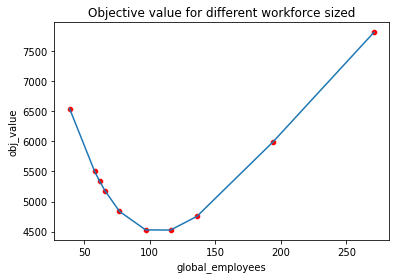

In [21]:
sns.lineplot(data=results_df, x='global_employees', y='obj_value')
sns.scatterplot(data=results_df, x='global_employees', y='obj_value', color='red')
plt.title(f"Objective value for different workforce sized")  # Adding title
plt.show()

In [22]:
# REGION RESULTS
region = 0
selected_areas = s.i.region_area_map[region]

region_results = results_df.query(f'region == {region}')

# OPTIMAL SOLUTION
optimal_n_employees = int(region_results.query(f'obj_value == {results_df["obj_value"].min()}')['n_employees'].values[0])
region_employees = {}
region_employees[region] = optimal_n_employees

i = Instance(regions=[region], areas=areas, 
    region_area_map=region_area_map, area_map=area_map, 
    period_demands=period_demands, period_couriers=period_couriers,
    region_employees=region_employees, min_hours_worked=6*8, max_hours_worked=6*8, max_unique_starts=2,
    shifts_start=shifts_start, shifts_end=shifts_end)

s = Solver(i)
s.solve()

UndefinedVariableError: name 'region' is not defined

In [ ]:
# Area Employee assignment (for each region)
area_employee_assignment = []
for e in s.employees:
    for a in areas:
        for theta in s.Theta:
            for d in s.D:
                for p in s.shifts:
                    shift = int(s.r_var[e, p, d].X)
                value = s.k_var[e, s.i.area_map[a], theta, d].X
                if value > 0.5:
                    area_employee_assignment.append([e, a, theta, d, shift])

area_employee_assignment_df = pd.DataFrame(area_employee_assignment, columns=['employee', 'area', 'period', 'day', 'shift'])

: 

In [ ]:
area_employee_assignment_df.query('employee == 0').sort_values(['day', 'period'])

: 

In [ ]:
couriers_needed_ = []
for d in s.D:
    data = (
        pd.DataFrame(s.couriers_needed[:,:,d], index=areas, columns=s.Theta).reset_index()
        .rename(columns={'index': 'area'})
        #.assign(day = d)
    )

    area_day_data = (
        pd.melt(data, id_vars=['area'], value_vars=set(data.columns).difference('area'))
        .rename(columns={'variable': 'period', 'value': 'n_couriers'})
        .assign(day = d)
    )
    couriers_needed_.append(area_day_data)

couriers_needed_df = pd.concat(couriers_needed_)

# Demand
deliveries_ = []
for d in s.D:
    data = (
        pd.DataFrame(s.deliveries[:,:,d], index=areas, columns=s.Theta).reset_index()
        .rename(columns={'index': 'area'})
        #.assign(day = d)
    )

    area_day_data = (
        pd.melt(data, id_vars=['area'], value_vars=set(data.columns).difference('area'))
        .rename(columns={'variable': 'period', 'value': 'deliveries'})
        .assign(day = d)
    )
    deliveries_.append(area_day_data)

deliveries_df = pd.concat(deliveries_)

couriers_needed_df = pd.merge(couriers_needed_df, deliveries_df, on=['area', 'period', 'day'])
couriers_needed_df.head()

# areas
area_period_days_df = (
    area_employee_assignment_df
    .groupby(['area', 'period', 'day'])
    .agg({'employee': ['count', 'unique']})
    .reset_index()
)
area_period_days_df.columns = ['area', 'period', 'day', 'employee_count', 'employees_assign']
area_period_days_df

# Outsourcing
outsourcing_shifts = []
for a in areas:
    for theta in s.Theta:
        for d in s.D:
            value = s.omega_var[s.i.area_map[a],theta,d].X
            #print(f'{a} {theta} {d} : {value}')
            if value > 0.0:
                outsourcing_shifts.append([a, theta, d, value])

outsourcing_shifts_df = pd.DataFrame(outsourcing_shifts, columns=['area', 'period', 'day', 'cost_outsource'])

# Join all
whole_solution_df = (
    couriers_needed_df
    # Employees
    .merge(area_period_days_df,  on=['area', 'period', 'day'], how='left')
    # Outsource
    .merge(outsourcing_shifts_df, on=['area', 'period', 'day'], how='left')
)
# DROP AREAS NOT IN REGION!!
whole_solution_df = whole_solution_df.query(f'area.isin({selected_areas})')
whole_solution_df['employee_count'].fillna(0, inplace=True)

whole_solution_df.query('deliveries != 0').head(30)

: 

In [ ]:
employees_shifts = []
for e in s.employees:
    for p in s.shifts:
        for d in s.D:
            value = s.r_var[e, p, d].X
            if value > 0.5:
                employees_shifts.append({'employee': e, 'shift': p, 'day':d, 'value': value})

employees_shifts_df = pd.DataFrame(employees_shifts)
employees_shifts_df.head()

day_employees_shifts_df = employees_shifts_df.groupby(['day', 'shift'])['value'].sum().reset_index()
day_employees_shifts_df

: 

In [ ]:
for d in s.D:
    _ = whole_solution_df.query(f'day == {d}').groupby('period').agg({'n_couriers': 'sum', 'employee_count': 'sum'})
    _.columns = ['n_couriers_sum', #'n_couriers_mean', 'n_couriers_min', 'n_couriers_max',
                 'employees_sum' #'employees_mean', 'employees_min', 'employees_max'
                ]
    
    a = pd.melt(_.reset_index(), id_vars='period', value_vars=['n_couriers_sum', 'employees_sum'])
    plt.figure(figsize=(10, 6))

    sns.barplot(data=a, x='period', y='value', hue='variable', alpha=0.5)

    # SHIFTS
    for key, x in s.i.shifts_start[region].items():
        start = s.i.shifts_start[region][key]
        end = s.i.shifts_end[region][key]+1
        
        if int(key) in list(day_employees_shifts_df.query(f'day == {d}')['shift'].values):
            workers = day_employees_shifts_df.query(f'shift == {int(key)} & day == {d}')['value'].values[0]
            #periods_ = [x for x in range(8) if i in range(start, end)]

            sns.scatterplot(x=[p for p in range(8)], y=[workers if i >= start and i < end else 0 for i in range(8)], label=f'Employees working at shift {key} : {start} - {end}')

    plt.title(f"Mean Couriers and Employee Count for Day {d} over all areas - Region: {region}")  # Adding title
    plt.legend(loc='upper right')  # Displaying legend
    
    plt.show()

: 